In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import catboost as catb

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
   
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
class ArrToDf(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y = None):
        X = pd.DataFrame(X, columns = self.columns)

        return X

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
all_columns = categorical_columns + continuous_columns

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [9]:
feats = FeatureUnion(final_transformers)

In [10]:
def get_classifier_metrics(b, classifier, y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    roc_auc = roc_auc_score(y_true=y_test, y_score = classifier.predict_proba(X_test)[:,1])
    return roc_auc, fscore[ix], precision[ix], recall[ix], thresholds[ix]

In [11]:
def get_pred_rates(th, y_test, y_score):
    cnf_matrix = confusion_matrix(y_test, y_score>th)

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

#     TPR = TP/(TP+FN)
#     FPR = FP/(FP+TN)
#     TNR = TN/(FP+TN)
    
    return TN, FN, TP, FP, cnf_matrix

In [12]:
def profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2):
    total_cost = cost_per_one * (TP + FP) # потратим на возвращение всех предсказанных
    total_rev = rev_per_one * TP # получим с правильно предсказанных
    total_loss = (-1) * rev_per_one * FN # недополучим с пропущенных, ткк они уйдут
    total_profit = total_rev - total_cost
    
    return total_profit, total_loss

In [13]:
lr = LogisticRegression(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
catboost = catb.CatBoostClassifier(silent = True, random_state = 42)
lgbmc = lgbm.LGBMClassifier(random_state = 42)

models = [lr, rf, catboost, lgbmc]

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


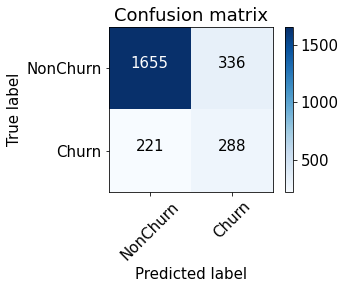

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


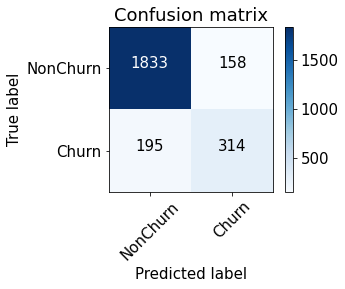

Confusion matrix, without normalization
[[1826  165]
 [ 188  321]]


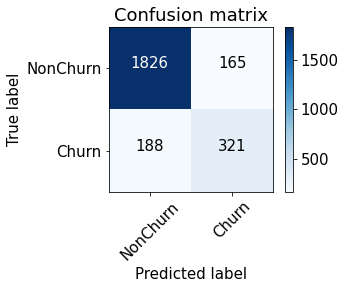

Confusion matrix, without normalization
[[1729  262]
 [ 144  365]]


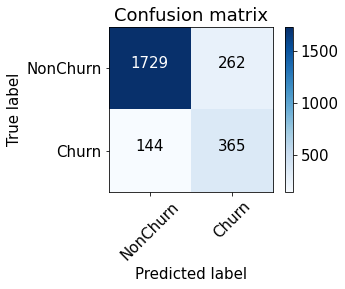

Wall time: 7.36 s


In [14]:
%%time
res = {}
for model in models:
    classifier = Pipeline([
    ('features',feats),
    ('classifier', model),
    ])
    
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(1, classifier, y_test, y_score)
    TN, FN, TP, FP, cnf_matrix = get_pred_rates(threshold, y_test, y_score)
    
    font = {'size' : 15}
    plt.rc('font', **font)
#     cnf_matrix = confusion_matrix(y_test, y_score > threshold)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
    plt.show()
    
    total_profit, total_lost_inc = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
    
    res['model_' + format(model)] = [roc_auc, fscore, precision, recall, TN, FN, TP, FP, total_profit, total_lost_inc]

In [15]:
models_compare = pd.DataFrame.from_dict(res, orient='index', columns = ['roc_auc', 'fscore', 'precision', 'recall', 'TN', 'FN', 'TP', 'FP', 'total_profit', 'total_lost_inc'])
models_compare

,roc_auc,fscore,precision,recall,TN,FN,TP,FP,total_profit,total_lost_inc
model_LogisticRegression(random_state=42),0.772077,0.509700,0.462400,0.567780,1655,221,288,336,-48,-442
model_RandomForestClassifier(random_state=42),0.863699,0.641283,0.654397,0.628684,1833,195,314,158,156,-390
model_<catboost.core.CatBoostClassifier object at 0x000001C58077DC08>,0.876942,0.646586,0.661191,0.632613,1826,188,321,165,156,-376
model_LGBMClassifier(random_state=42),0.871872,0.643799,0.582803,0.719057,1729,144,365,262,103,-288


* catboost не сильно выигрывает по f1 и roc_auc у lgbm. Предположим, что мы сумеем вернуть каждого верно предсказанного. При стоимости удержания 1 USD и средней ожидаемой прибыли с каждого возвращенного 2 USD (соответственно, и потере с каждого пропущенного отчурнившегося тоже в 2 USD) total_profit у catboost выше
* Total_profit у RandomForest при заданных условиях получилась одинаковая c catboost. Но размер недополученной прибыли у catboost ниже, что объясняется более высоким recall - меньше пропущенных моделью объектов положительного класса (FN). Прочие метрики качества у catboost выше, чем у случайного леса

### Catboost params tuning

#### cate features on the classifier's side

In [16]:
catb_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', NumberSelector(key=cat_col)),
#                 ('ohe', OHEEncoder(key=cat_col)),
            ])
    catb_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler()),
            ])
    catb_transformers.append((cont_col, cont_transformer))

catb_feats = FeatureUnion(catb_transformers)

In [17]:
catb_pipeline_cat_features = Pipeline([
    ('features', catb_feats),
    ('make_df', ArrToDf(columns = all_columns)),
    ('classifier', catb.CatBoostClassifier(silent = True, cat_features = categorical_columns, random_state = 42)),
])

In [18]:
catb_pipeline_cat_features.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='HasCrCard')...
             

In [19]:
preds = catb_pipeline_cat_features.predict_proba(X_test)[:, 1]
preds[:10]

array([0.40029729, 0.24441118, 0.13580742, 0.04639617, 0.02159113,
       0.78638343, 0.01453551, 0.08366922, 0.20418666, 0.89933209])

In [20]:
roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(1, catb_pipeline_cat_features, y_test, preds)
fscore, precision, recall, threshold

(0.6487006737247353,
 0.6358490566037736,
 0.6620825147347741,
 0.3510422212914368)

In [21]:
TN, FN, TP, FP, cnf_matrix = get_pred_rates(threshold, y_test, preds)
TN, FN, TP, FP

(1798, 173, 336, 193)

Confusion matrix, without normalization
[[1798  193]
 [ 173  336]]


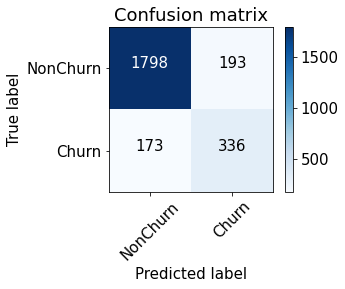

In [22]:
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

In [23]:
total_profit = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
total_profit

(143, -346)

При обработке категориальных фич на стороне классификатора мы выиграли в f1, но проиграли в выручке, при этом немного уменьшив FN, однако, сильно увеличив FP.

#### GridSearch

In [24]:
params={'classifier__n_estimators':[100, 500, 1000, 2000], # default 1000
        'classifier__max_leaves':[21, 31, 51], # default 31
        'classifier__l2_leaf_reg' : [1e-3, 1e-2, 1e-1, 1, 2, 3], # default 3
        'classifier__depth':[4, 6, 8, 10] #default 6
        }

In [25]:
# cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 42)
# rs = RandomizedSearchCV(catb_pipeline_cat_features, params, n_jobs = -1, scoring = 'f1', cv = cv, verbose = 10)

# search = rs.fit(X_train, y_train)


Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [26]:
# search.best_params_, search.best_score_

({'classifier__n_estimators': 500,
  'classifier__max_leaves': 31,
  'classifier__l2_leaf_reg': 3,
  'classifier__depth': 8},
 0.5838026168461833)

#### Final model

In [27]:
pipeline_final = Pipeline([
    ('features', catb_feats),
    ('make_df', ArrToDf(columns = all_columns)),
    ('classifier', catb.CatBoostClassifier(silent = True, n_estimators = 500, max_leaves = 31, l2_leaf_reg = 3, depth = 8, cat_features = categorical_columns, random_state = 42)),
#     ('classifier', catb.CatBoostClassifier(silent = True, n_estimators = 2000, max_leaves = 31, l2_leaf_reg = 0.001, depth = 4, cat_features = categorical_columns, random_state = 42)),
])

In [28]:
pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='HasCrCard')...
             

In [29]:
#наши прогнозы для тестовой выборки
preds = pipeline_final.predict_proba(X_test)[:, 1]
preds[:10]

array([0.33773597, 0.25515941, 0.139047  , 0.04654424, 0.02089156,
       0.78412287, 0.00936777, 0.10745681, 0.19546456, 0.88949994])

In [30]:
roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(1, pipeline_final, y_test, preds)

In [31]:
fscore, precision, recall, threshold

(0.6486486486486486,
 0.6612244897959184,
 0.6365422396856582,
 0.3715607480116914)

In [32]:
TN, FN, TP, FP, cnf_matrix = get_pred_rates(threshold, y_test, preds)
TN, FN, TP, FP

(1825, 186, 323, 166)

Confusion matrix, without normalization
[[1825  166]
 [ 186  323]]


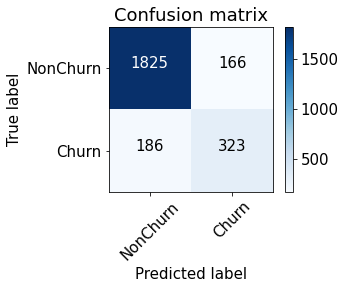

In [33]:
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

In [34]:
total_profit = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
total_profit

(157, -372)

f-score практически не изменился по сравнению с базовым алгоритмом с категориальными фичами, выручка модели немного выросла

In [35]:
def get_maxprofit_metrics(b, classifier, y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    
    profit = []
    loss = []
    for th in thresholds:
        cnf_matrix = confusion_matrix(y_test, y_score > th)

        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        total_profit, total_loss = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
        profit.append(total_profit)
        loss.append(total_loss)
#     locate the index of the largest f score
    ix = np.argmax(profit)

    return thresholds[ix], profit[ix], loss[ix], fscore[ix], precision[ix], recall[ix]

In [36]:
get_maxprofit_metrics(1, pipeline_final, y_test, preds)

(0.5329656051009825,
 190,
 -484,
 0.6252927400468384,
 0.7739130434782608,
 0.5245579567779961)

In [37]:
models_compare.iloc[2]

roc_auc              0.876942
fscore               0.646586
precision            0.661191
recall               0.632613
TN                1826.000000
FN                 188.000000
TP                 321.000000
FP                 165.000000
total_profit       156.000000
total_lost_inc    -376.000000
Name: model_<catboost.core.CatBoostClassifier object at 0x000001C58077DC08>, dtype: float64

Еще немного улучшили экономические метрики, выбрав трешхолд по максимальной выручке, но при этом мы пропускаем больше объектов положительного класса

#### Вывод: выбор максимальной DS метрики модели в реальной ситуации - далеко не гарантия максимальной экономической эффективности